# Лабораторная работа №1. "Динамическая модель многозвенного манипулятора"
***Выполнил***: Краев Иван Юрьевич R4134c

## Задачи работы:
Создать и дополнить модель монипулятора с использованием библиотеки **roboticstoolbox**. Решить обратную задачу динамики с использованием модели.

In [2]:
# !pip install roboticstoolbox-python==1.0.2 numpy==1.26.4 scipy==1.11.4


In [69]:
from math import pi
import math
import numpy as np
import matplotlib.pyplot as plt
import roboticstoolbox as rtb

# 1. Выбор модели
В качестве модели для выполнения лабораторной выберем манипулятор Kuka KR5

In [70]:
robot = rtb.models.DH.KR5()
print(robot)


DHRobot: KR5 (by KUKA), 6 joints (RRRRRR), dynamics, geometry, standard DH parameters
┌─────┬────────┬──────┬────────┬─────────┬────────┐
│ θⱼ  │   dⱼ   │  aⱼ  │   ⍺ⱼ   │   q⁻    │   q⁺   │
├─────┼────────┼──────┼────────┼─────────┼────────┤
│  q1 │    0.4 │ 0.18 │ -90.0° │ -155.0° │ 155.0° │
│  q2 │      0 │  0.6 │   0.0° │ -180.0° │  65.0° │
│  q3 │      0 │ 0.12 │  90.0° │  -15.0° │ 158.0° │
│  q4 │  -0.62 │    0 │ -90.0° │ -350.0° │ 350.0° │
│  q5 │      0 │    0 │  90.0° │ -130.0° │ 130.0° │
│  q6 │ -0.115 │    0 │ 180.0° │ -350.0° │ 350.0° │
└─────┴────────┴──────┴────────┴─────────┴────────┘

┌──┬──┐
└──┴──┘

┌──────┬──────┬──────┬──────┬──────┬──────┬──────┐
│ name │ q0   │ q1   │ q2   │ q3   │ q4   │ q5   │
├──────┼──────┼──────┼──────┼──────┼──────┼──────┤
│   qr │  45° │  60° │  45° │  30° │  45° │  30° │
│   qz │  0°  │  0°  │  0°  │  0°  │  0°  │  0°  │
│  qk1 │  45° │  60° │  45° │  30° │  45° │  30° │
│  qk2 │  45° │  60° │  30° │  60° │  45° │  30° │
│  qk3 │  30° │  60

# 2. Определение параметров

Общий вес робота Kuka KR5, согласно документации, равен 127 килограмм. На основе габаритов робота сделаем предположение о распределении общей массы по каждому из звеньев

In [71]:
robot.links[0].m = 40;
robot.links[1].m = 30;
robot.links[2].m = 30;
robot.links[3].m = 14;
robot.links[4].m = 8;
robot.links[5].m = 5;

Зададим центры масс для каждого звена в геометрическом центре модели
этого звена

In [72]:
robot.links[0].r = [0, 0, robot.links[0].a/2];
robot.links[1].r = [0, robot.links[1].a/2, 0];
robot.links[2].r = [0, robot.links[2].a/2, 0];
robot.links[3].r = [0, -robot.links[3].a/2, 0];
robot.links[4].r = [0, robot.links[4].a/2, 0];
robot.links[5].r = [0, 0, robot.links[5].a/2];


Выбираем тензоры инерции относительно центров масс. Предположим, что каждое звено имеет цилиндрическую форму. 

In [73]:
r = 0.2; # Радиус цилиндрического звена
robot.links[0].I = np.array([[robot.links[0].m * (3 * r**2 + robot.links[0].a**2)  / 12, 0, 0],
                    [0, robot.links[0].m * (3 * r**2 +robot.links[0].a**2)  / 12,  0],
                    [0, 0, robot.links[0].m * robot.links[0].a**2 /2]])

robot.links[1].I = np.array([[robot.links[1].m * robot.links[1].a**2 / 12, 0, 0],
                    [0, 0, 0],
                    [0, 0, robot.links[1].m * robot.links[1].a**2 /12]])

robot.links[2].I = np.array([[robot.links[2].m * robot.links[2].a**2 / 12, 0, 0],
                    [0, 0, 0],
                    [0, 0, robot.links[2].m * robot.links[2].a**2 /12]])


robot.links[3].I = np.array([[robot.links[3].m * (3 * r**2 + robot.links[3].a**2)  / 12, 0, 0],
                    [0, robot.links[3].m * (3 * r**2 +robot.links[3].a**2)  / 12,  0],
                    [0, 0, robot.links[3].m * robot.links[3].a**2 /2]])

robot.links[4].I = np.array([[robot.links[4].m * robot.links[4].a**2 / 12, 0, 0],
                    [0, 0, 0],
                    [0, 0, robot.links[4].m * robot.links[4].a**2 /12]])

robot.links[5].I = np.array([[robot.links[5].m * (3 * r**2 + robot.links[5].a**2)  / 12, 0, 0],
                    [0, robot.links[5].m * (3 * r**2 + robot.links[5].a**2)  / 12,  0],
                    [0, 0, robot.links[5].m * robot.links[5].a**2 / 2]])

Выставим ограничения по обобщённым координатам:

In [74]:
robot.links[0].qlim = np.array([math.radians(-155), math.radians(155)])
robot.links[1].qlim = np.array([math.radians(-180), math.radians(65)])
robot.links[2].qlim = np.array([math.radians(-15), math.radians(158)])
robot.links[3].qlim = np.array([math.radians(-350), math.radians(350)])
robot.links[4].qlim = np.array([math.radians(-130), math.radians(130)])
robot.links[5].qlim = np.array([math.radians(-350), math.radians(350)])


Установим моменты инерции моторов:

In [75]:
robot.links[0].Jm = 0.05
robot.links[1].Jm = 0.05
robot.links[2].Jm = 0.05
robot.links[3].Jm = 0.05
robot.links[4].Jm = 0.05
robot.links[5].Jm = 0.05

Передаточные числа редукторов:

In [76]:
robot.links[0].G = 1
robot.links[1].G = 1
robot.links[2].G = 1
robot.links[3].G = 1
robot.links[4].G = 1
robot.links[5].G = 1

# 3. Определение начальной и конечной конфигураций
Визуализируем начальный и конечный набор обобщённых координат

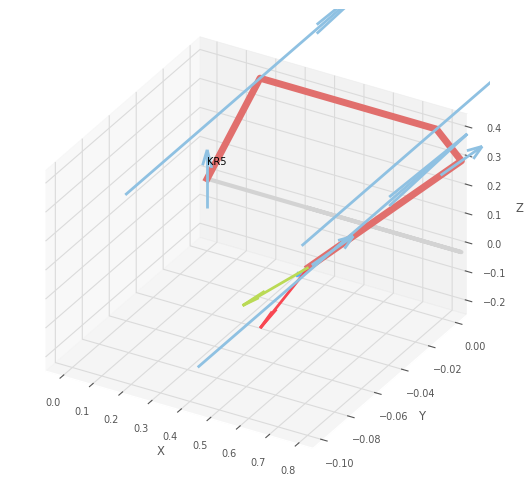

<Figure size 640x480 with 0 Axes>

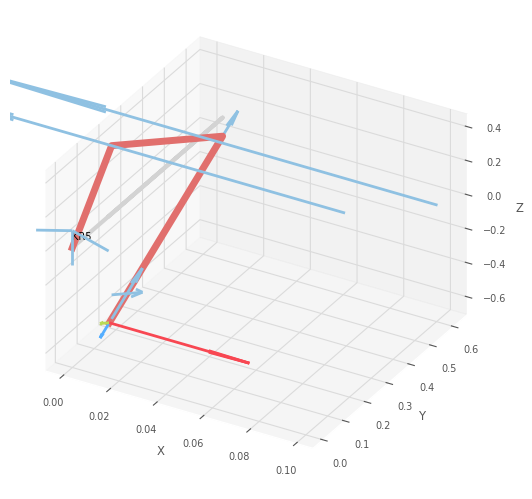

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'KR5')

<Figure size 640x480 with 0 Axes>

In [77]:
q_init = np.array([0, 0, pi/4, 0, 0, -pi/4])
q_final = np.array([pi/2, pi/4, 0, -pi/2, 0, 0])
robot.plot(q_init, backend='pyplot')
robot.plot(q_final, backend='pyplot')

# 4. Планирование траектории

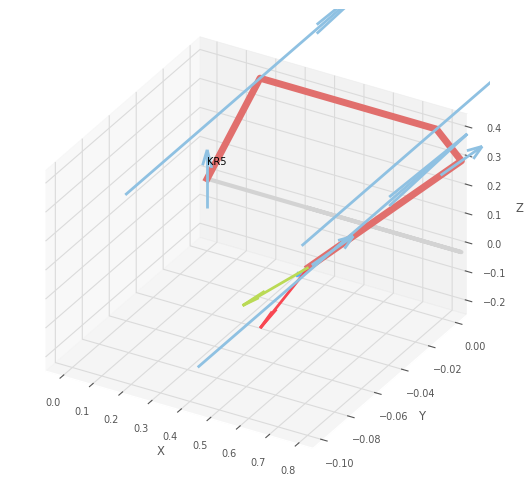

PyPlot3D backend, t = 2.0500000000000007, scene:
  robot: Text(0.0, 0.0, 'KR5')

<Figure size 640x480 with 0 Axes>

In [96]:
t = np.arange(0.0, 2.05, 0.05)
Q = rtb.jtraj(q_init, q_final, t)
robot.plot(Q.q, backend='pyplot', movie="kuka.gif")


![SegmentLocal](kuka.gif "segment")

# 5. Решение обратной задачи динамики
Решим обратную задачу динамики методом Ньютона-Эйлера для разных сценариев

## a) Ненулевые скорости и ускорения

In [111]:
tau_0 = robot.rne(Q.q, Q.qd, Q.qdd)
M = robot.inertia(Q.q)
C = robot.coriolis(Q.q, Q.qd)
G = robot.gravload(Q.q);
# Не будем выводить численные значения матриц Tau, M, C, G в целях экономии места.

## b) Ненулевые скорости и пренебрежительно малые ускорения (квазистатика)

In [112]:
tau_1 = robot.rne(Q.q, Q.qd, Q.qdd * 1e-15)
M = robot.inertia(Q.q)
C = robot.coriolis(Q.q, Q.qd)
G = robot.gravload(Q.q);



## c) Нулевые скорости и ускорения (статика)

In [113]:
tau_2 = robot.rne(Q.q, np.zeros(Q.q.shape), np.zeros(Q.q.shape))
M = robot.inertia(Q.q)
C = robot.coriolis(Q.q, Q.qd)
G = robot.gravload(Q.q);

## Отобразим графики
Ниже представлены графики моментов звеньев вдоль траектории для каждого случая.

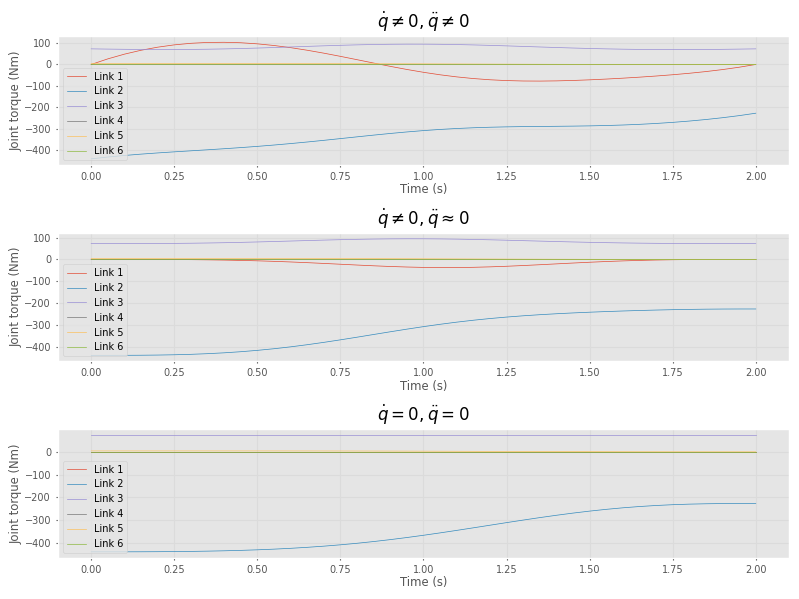

In [116]:

# Create the subplot
fig, ax = plt.subplots(3, 1, figsize=(8, 6))  # 3 rows, 1 column
# Plot in the first subplot (subplot(3,1,2) in MATLAB)
ax[0].plot(t, tau_0[:, 0:6])  # Plot the first 6 columns of tau
# Set labels
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Joint torque (Nm)')
# Set legend
ax[0].legend(["Link 1", "Link 2", "Link 3", "Link 4", "Link 5", "Link 6"])
# Set title with LaTeX interpreter
ax[0].set_title(r"$\dot{q} \neq 0, \ddot{q} \neq 0$", fontsize=12)

ax[1].plot(t, tau_1[:, 0:6])  # Plot the first 6 columns of tau
# Set labels
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Joint torque (Nm)')
# Set legend
ax[1].legend(["Link 1", "Link 2", "Link 3", "Link 4", "Link 5", "Link 6"])
# Set title with LaTeX interpreter
ax[1].set_title(r"$\dot{q} \neq 0, \ddot{q} \approx 0$", fontsize=12)

ax[2].plot(t, tau_2[:, 0:6])  # Plot the first 6 columns of tau
# Set labels
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Joint torque (Nm)')
# Set legend
ax[2].legend(["Link 1", "Link 2", "Link 3", "Link 4", "Link 5", "Link 6"])
# Set title with LaTeX interpreter
ax[2].set_title(r"$\dot{q} = 0, \ddot{q} = 0$", fontsize=12)
# Adjust layout and show the plot
plt.tight_layout()
plt.show()
